<a href="https://colab.research.google.com/github/pswami12/DataScienceFiles/blob/main/Class_10_AIDL_CIFAR10_ResNet_Sol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

import statistics

In [ ]:
print('PyTorch version:', torch.__version__)
print('Torchvision version:', torchvision.__version__)

PyTorch version: 1.12.1+cu113
Torchvision version: 0.13.1+cu113


In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])

In [ ]:
cuda = torch.device('cuda')

model = ResNet34()
model.to(cuda)

In [ ]:
dataset_transform = transforms.Compose([
    transforms.ToTensor()
])

train_set = CIFAR10('./cifar10', train=True, download=True, transform=dataset_transform)
valid_set = CIFAR10('./cifar10', train=False, download=True, transform=dataset_transform)

print(train_set.data.shape)
print(valid_set.data.shape)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10
Files already downloaded and verified
(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [ ]:
train_loader = DataLoader(train_set, batch_size=128, num_workers=0, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=512, num_workers=0, shuffle=False)

In [ ]:
x = torch.randn(128, 3, 32, 32, device=cuda)
output = model(x)
print(output.shape)

torch.Size([128, 10])


## Training the Model

**Optimizer: Stochastic Gradient Descent**

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

**Train function**

In [ ]:
def train(model, loss_fn, optimizer):
    model.train()

    train_batch_losses = []

    for batch, labels in train_loader:
        batch = batch.to(cuda)
        labels = labels.to(cuda)

        optimizer.zero_grad()
        y_pred = model(batch)
        loss = loss_fn(y_pred, labels)
        loss.backward()
        optimizer.step()

        train_batch_losses.append(float(loss))

        mean_loss = statistics.mean(train_batch_losses)

    return mean_loss

**Validation function**

In [ ]:
def validate(model, loss_fn, optimizer):
    model.eval()

    predictions = []

    with torch.no_grad():
        validation_batch_losses = []

        for batch, labels in valid_loader:
            batch = batch.to(cuda)
            labels = labels.to(cuda)

            labels_pred = model(batch)
            loss = loss_fn(labels_pred, labels)

            validation_batch_losses.append(float(loss))

            mean_loss = statistics.mean(validation_batch_losses)

    return mean_loss

**Accuracy function**

In [ ]:
def accuracy(model, loader):
    correct = 0
    total = 0

    model.eval()

    with torch.no_grad():
        for batch, labels in loader:
            batch = batch.to(cuda)
            labels = labels.to(cuda)

            labels_pred = model(batch)

            _, predicted = torch.max(labels_pred.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return (100 * correct / total)

### Training our Convnet on CIFAR-10

In [ ]:
loss_fn = nn.CrossEntropyLoss()

epochs = 5

train_losses = []
valid_losses = []

train_accuracies = []
valid_accuracies = []

for epoch in range(1, epochs +  1):

    print('Epoch: ', epoch)

    train_loss = train(model, loss_fn, optimizer)
    train_accuracy = accuracy(model, train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print('Training loss:', train_loss)
    print('Training accuracy: {}%'.format(train_accuracy))

    valid_loss = validate(model, loss_fn, optimizer)
    valid_accuracy = accuracy(model, valid_loader)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)

    print('Validation loss:', valid_loss)
    print('Validation accuracy: {}%'.format(valid_accuracy))

Epoch:  1
Training loss: 2.0923136987954454
Training accuracy: 38.29%
Validation loss: 1.6331610143184663
Validation accuracy: 37.72%
Epoch:  2
Training loss: 1.5557287263748285
Training accuracy: 47.866%
Validation loss: 1.431675910949707
Validation accuracy: 46.27%
Epoch:  3
Training loss: 1.3044112128065066
Training accuracy: 49.694%
Validation loss: 1.482366806268692
Validation accuracy: 48.13%
Epoch:  4
Training loss: 1.0739703007671229
Training accuracy: 63.858%
Validation loss: 1.0966783493757248
Validation accuracy: 61.42%
Epoch:  5
Training loss: 0.8685752039065446
Training accuracy: 70.652%
Validation loss: 0.9647608131170273
Validation accuracy: 67.69%


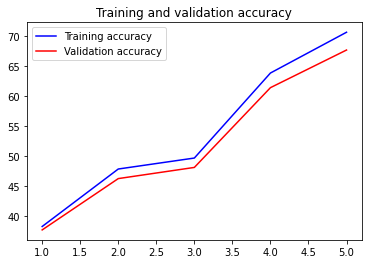

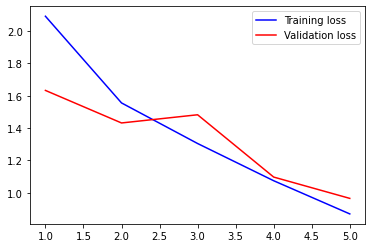

In [ ]:
import matplotlib.pyplot as plt

epoch = range(1, epochs + 1)

plt.plot(epoch, train_accuracies, 'b', label='Training accuracy')
plt.plot(epoch, valid_accuracies, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epoch, train_losses, 'b', label='Training loss')
plt.plot(epoch, valid_losses, 'r', label='Validation loss')
plt.legend()

plt.show()